# HW2-Celestial Mechanics
Giacomo Menegatti (2122852)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 
from scipy.interpolate import interp1d


## Explicit implementation of a Runge-Kutta integrator

The fourth order Runge-Kutta method for integrating an ODE of the type $$ \ddot y = f(t,y) $$
evaluates the function f multiple times during a step following the schema: 

\begin{align}

   & k_1 = h \cdot f(t_n, y_n)  \notag\\
  & k_2 = h \cdot f(t_n + 0.5h, y_n+0.5k_1)  \notag\\
  & k_3 = h \cdot f(t_n + 0.5h, y_n+0.5k_2)  \notag\\
  & k_4 = h \cdot f(t_n +h , y_n+k_3)  \notag\\
  & t_{n+1} = t_n+h  \notag\\
  & y_{n+1} = y_n + \frac{1}{6}(k_1+2k_2+2k_3+k_4)  \notag

\end{align}

In [3]:
def RK(f, y0, t0, tf, h):
  #Creating two arrays
  Y = [y0]
  T = [t0]
  t = t0
  while t < tf:
    
    y = np.array(Y[-1])

    #Runge Kutta coefficients
    k1 = h*f(t,y)
    k2 = h*f(t + 0.5*h, y + 0.5*k1)
    k3 = h*f(t + 0.5*h, y + 0.5*k2)
    k4 = h*f(t + h, y + k3)
        
    y = y + (k1 + 2*k2 + 2*k3 + k4)/6.0
    t  = t + h

    Y.append(y)
    T.append(t)
  # I transpose the array to have the same shape as the scipy one
  # meaning [[y1(t0),...,y1(tf)],....,[yn(t0),...,yn(tf)]]
    
  #Dense output
  Y = interp1d(T, np.array(Y).T) 

  return T, Y



## Adaptive step Runge-Kutta
The code is equal to the one before, just now h is a function of t and y instead of a constant.

In [4]:
def RK_Adaptive(f, y0, t0, tf, hf):

  #Creating two arrays
  Y = [y0]
  T = [t0]
  t = t0
  
  while t < tf:
    
    y = np.array(Y[-1])
    h = hf(t, y)

    #Runge Kutta coefficients
    k1 = h*f(t,y)
    k2 = h*f(t + 0.5*h, y + 0.5*k1)
    k3 = h*f(t + 0.5*h, y + 0.5*k2)
    k4 = h*f(t + h, y + k3)
        
    y = y + (k1 + 2*k2 + 2*k3 + k4)/6.0
    t  = t + h

    Y.append(y)
    T.append(t)
  # I transpose the array to have the same shape as the scipy one
  # meaning [[y1(t0),...,y1(tf)],....,[yn(t0),...,yn(tf)]]
  #Dense output
  Y = interp1d(T, np.array(Y).T) 

  return T, Y


# Two-body integration

In [5]:
# ODE function
def two_body_ODE(t,y, GM):
  #Dividing y in positions and velocities
  r1, r2  = y[0:2], y[2:4]  #The first four variables are positions
  v1, v2 = y[4:6], y[6:8]  #The next four are velocities
  #Calculating the accelerations
  r_12 = r2-r1
  r3 = np.linalg.norm(r_12)**3
  

  #With concatenate I concatenate vectors side by side to get the state vector
  return np.array(np.concatenate((v1, v2, GM/r3*r_12, -GM/r3*r_12), axis=None))


Function to calculate the energy (NB: here y is a matrix, so extra care must be used in manipulating it)

In [6]:

def relative_Energy(y, GM):

  r1, r2  = y[0:2], y[2:4]  #The first four variables are positions
  v1, v2 = y[4:6], y[6:8]  #The next four are velocities
  
  # Calculating the energy and its relative variation
  # v1 and v2 are matrixes, with on one axis the time and on the other the direction (x or y)
  # I sum on the first axis, the direction, so they become vectors depending on the time

  E = 0.5*np.sum(v1**2, axis= 0) + 0.5*np.sum(v2**2, axis= 0) - GM/np.linalg.norm(r2-r1, axis=0)
  return E/E[0]-1.0


Function to plot the trajectories and the relative energy

In [7]:
def plot_orbits(f, GM, t0, tf):
  T = np.linspace(t0, tf, 10000)
  y = f(T)
  #Calulating th energy
  E = relative_Energy(y, GM)

  fig, (ax0, ax1) = plt.subplots(1,2, figsize=(16,8))

  #Plotting the positions
  x1, y1, x2, y2, = y[0], y[1], y[2], y[3]

  ax0.set_title('Trajectories')
  ax0.plot(x1, y1, label = 'first mass')
  ax0.plot(x2, y2, label = 'second mass')
  CM = np.array([0.5*(x1+x2), 0.5*(y1+y2)])
  CM = np.array([0.5*(x1+x2), 0.5*(y1+y2)])
  ax0.plot(CM[0], CM[1], 'r:', label='center of mass')
  ax0.set_xlabel(r'x [$km$]')
  ax0.set_ylabel(r'y [$km$]')
  ax0.grid()
  
  T_annotate = np.linspace(t0, tf, 7)
  y = f(T_annotate)
  x1, y1, x2, y2 = y[0], y[1], y[2], y[3]
  ax0.plot(x1, y1, 'k.')
  ax0.plot(x2, y2, 'k.')
  offset = 2e4
  for i, (lx1, ly1, lx2, ly2)  in enumerate(zip(x1,y1,x2,y2)):
    ax0.annotate(f'{i}', (lx1-offset, ly1+offset), fontsize=10)
    ax0.annotate(f'{i}', (lx2-offset, ly2+offset), fontsize=10)

  ax0.legend()
  #Plotting the energy
  ax1.set_title('Relative energy variation')
  ax1.plot(T, 100*E, label='energy variation')
  ax1.set_xlabel('Time [s]')
  ax1.set_ylabel('% variation')
  ax1.legend(loc='best')
  ax1.grid()


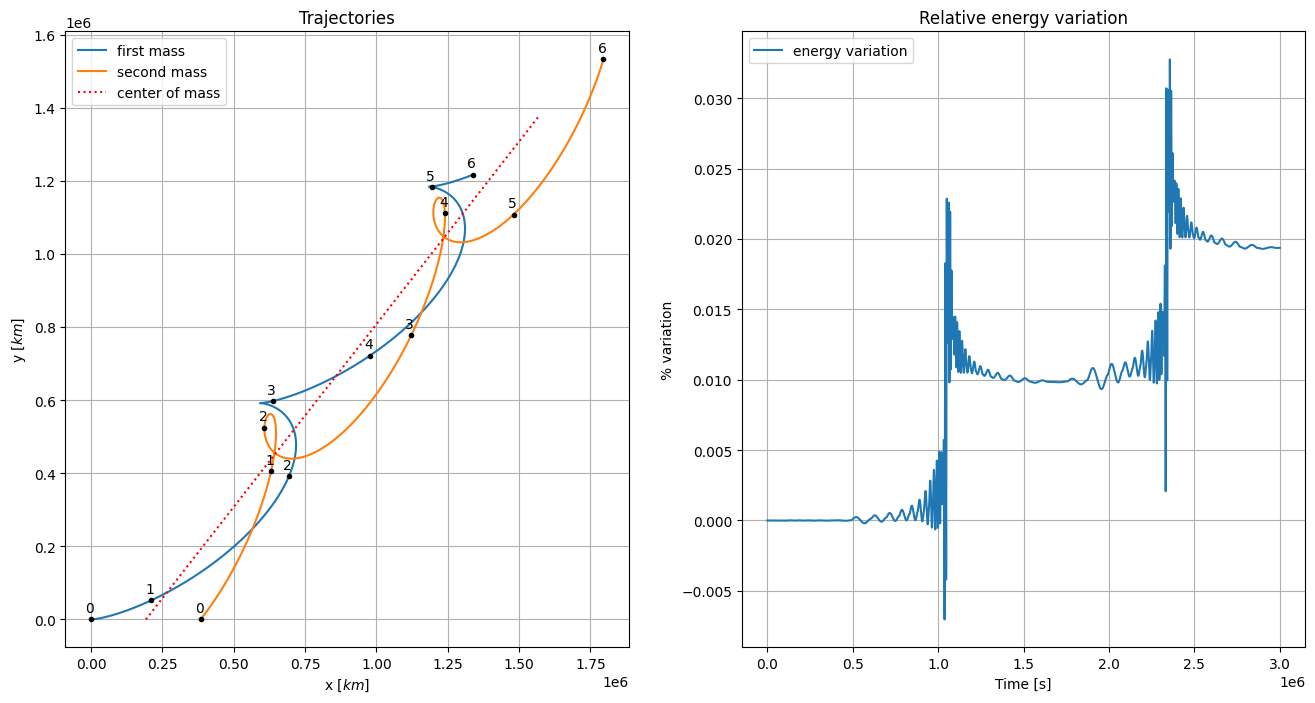

In [8]:
GM = 398600.4415
#Initial positions and velocities 
r1 = np.array([0,0])
r2 = np.array([384400,0])
v1 = np.array([0,0])
v2 = np.array([0.91647306922544, 0.91647306922544])

t0, tf = 0, 3e6

# Getting the modified state vector
y0 = np.concatenate((r1, r2, v1, v2), axis=None)

#With dense output I obtain the interpolating function
Y1 = solve_ivp(two_body_ODE, y0=y0, args=(GM,), t_span=(t0, tf), dense_output=True, rtol=1e-6)

plot_orbits(Y1.sol, GM, t0=t0, tf=tf)


In this plot, I added the black points to give some information about how the trajectories are percorred in time. I didn't write the complete timing information for these points to keep the plot cleaner. Each point is separated by the one before by $5\cdot 10 ^5 s$.
The energy is growing with sudden spikes in corrispondence of the close encounters.

The orbit seen from the Center of Mass shows that the two bodies are following elliptic orbits.

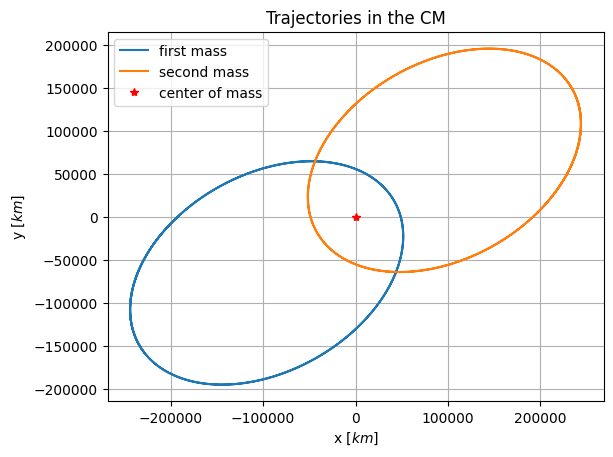

In [9]:
T = np.linspace(t0, tf, 10000)
y = Y1.sol(T)

#Plotting the positions
x1, y1, x2, y2, = y[0], y[1], y[2], y[3]
CM = np.array([0.5*(x1+x2), 0.5*(y1+y2)])
CM = np.array([0.5*(x1+x2), 0.5*(y1+y2)])

plt.title('Trajectories in the CM')
plt.plot(x1-CM[0], y1-CM[1], label = 'first mass')
plt.plot(x2-CM[0], y2-CM[1], label = 'second mass')
plt.plot(0, 0, 'r*', label = 'center of mass')
plt.xlabel(r'x [$km$]')
plt.ylabel(r'y [$km$]')
plt.legend()
plt.grid()


Here I repeated the integration by adding a more strict relative tollerance

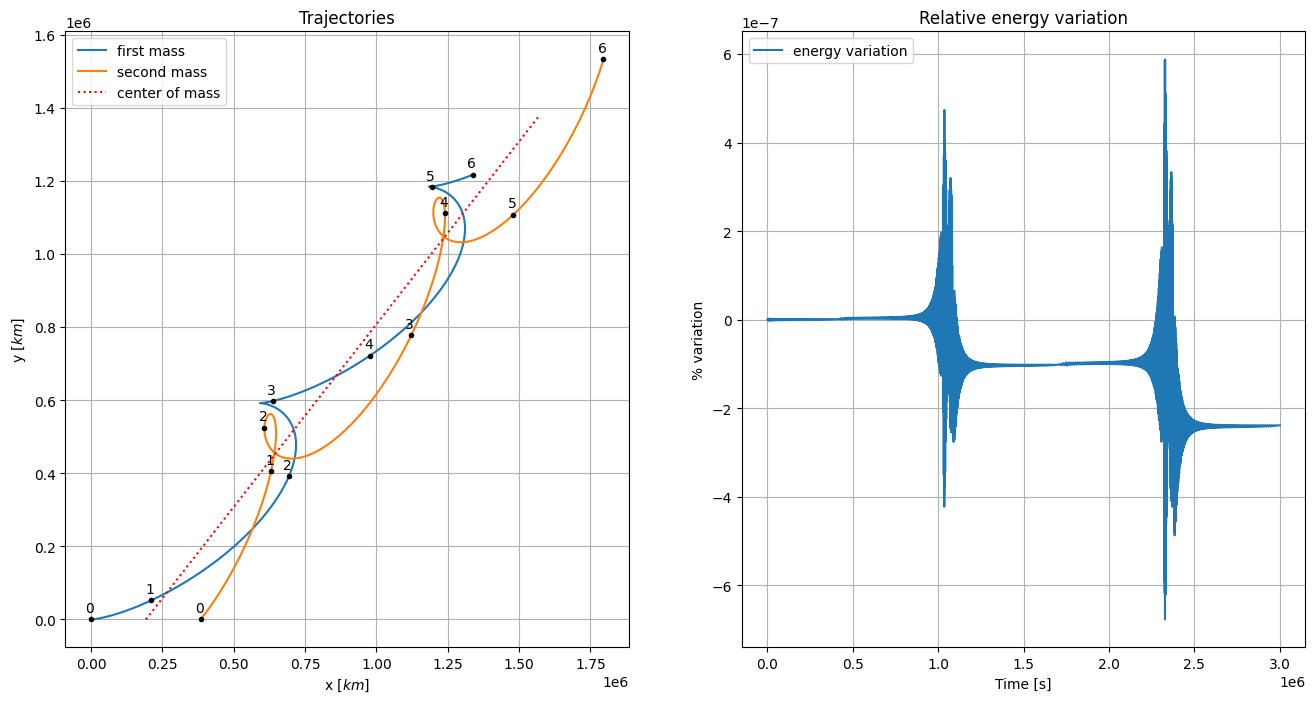

In [10]:
Y2 = solve_ivp(two_body_ODE, y0=y0, args=(GM,), t_span=(t0, tf), dense_output=True, rtol=1e-12)

plot_orbits(Y2.sol, GM, t0=t0, tf=tf)


With a smaller relative tollerance, the trajectories remain pretty much the same during the considere timestep. The energy is much more stable, with a relative variation between orbits of $\approx -1\cdot 10^{-7}$% instead of $0.01$ % for the previous case

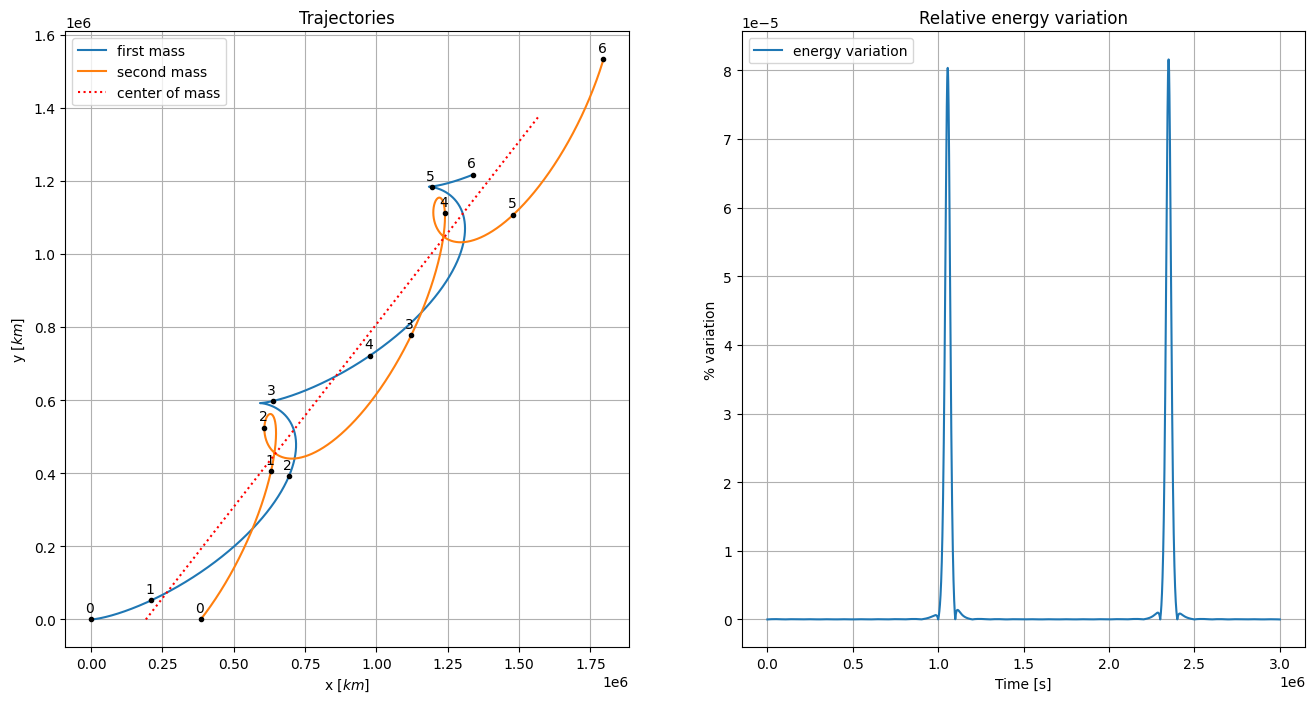

In [11]:
# While I can pass the gravitational paramter GM to the scipy integrator,
# I have to fix it manually here for my integrator

TB_ODE = lambda t,y : two_body_ODE(t,y, GM=GM)
T, Y3 = RK(TB_ODE, y0=y0, t0=t0, tf=tf, h=1e1)

plot_orbits(Y3, GM, t0=t0, tf=tf)


With a step size of $10s$, the system behaves like the others. The energy relative variation is of the order of $10^{-5}$ and behaves differently than the others because it doesn't oscillate but have only growing spikes. This could be caused by the fact that the scipy Ringe-Kutta is applying a variable step size while focusing on keeping the tolerance below the fixed treshold, while my method instead uses fixed time steps.

A confront between the discrepancies between the three methods

Text(0.5, 1.0, 'x1 evolution in time')

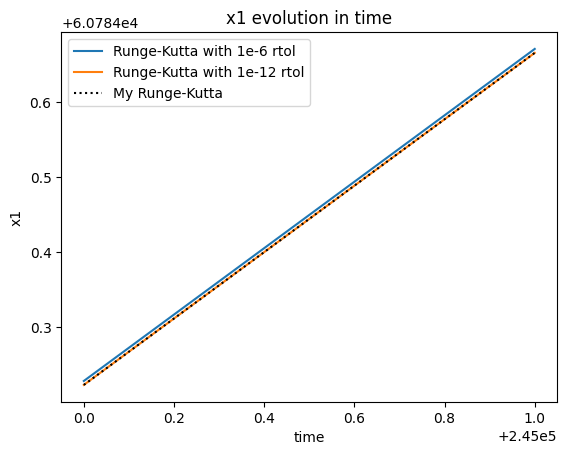

In [12]:
T = np.linspace(2.45e5, 2.45e5 + 1e0, 1000)

plt.plot(T, Y1.sol(T)[0], label = 'Runge-Kutta with 1e-6 rtol')
plt.plot(T, Y2.sol(T)[0], label = 'Runge-Kutta with 1e-12 rtol')
plt.xlabel('time')
plt.ylabel('x1')
plt.plot(T, Y3(T)[0], 'k:',  label = 'My Runge-Kutta')
plt.legend()
plt.title('x1 evolution in time')


The trajectories calculated can be distinguished over a time interval of 1 $s$, which is very small compared to the total time interval over which the data are integrated. Also, because there aren't many data to fit in such an interval, the interpolating function is nearly a straight line. The Runge-Kutta with a relative tolerance of $10^{-6}$ is separated from the other two lines, while the Runge Kutta with $10^{-12}$ tolerance and my implementation (the dotted line in the plot) with a step size of $10s$ are not distinghuishable at this scale.

# Burrau's problem
The Burrau's problem consists of three masses of 3,4,5 units of mass initially at rest at the vertices of the 3-4-5 pythagorean triangle. 
The system presents several close encounters that make the integration particularly difficult. 

The Szebehely-Peters paper, using a regularization method for close encounters, is able to use a fifth-order Runge-Kutta integrator to obtain a very precise solution of the problem. The solution predicts that the system is going to explode between 60 and 70 units of time when the smallest mass (3) is expelled from the system and the two largest masses form a close binary system. 

In this analysis I stopped the integrators when the integrating time started to go over 15 minutes. A better code optimized for speed and efficiency, will surely give better and more complete results.

In [13]:
# ODE function
def three_body_ODE(t,y, G, M):
  #Dividing y in positions and velocities
  r1, r2, r3 = y[0:2], y[2:4], y[4:6]  
  v1, v2, v3 = y[6:8], y[8:10], y[10:12] 
  #Calculating the accelerations
  r_12 = r2-r1
  r_13 = r3-r1
  r_23 = r3-r2
  
  a_12 = G*M[0]*M[1]*r_12/np.linalg.norm(r_12)**3
  a_13 = G*M[0]*M[2]*r_13/np.linalg.norm(r_13)**3
  a_23 = G*M[1]*M[2]*r_23/np.linalg.norm(r_23)**3
  #With concatenate I concatenate vectors side by side to get the state vector

  return np.concatenate((v1, v2, v3,  a_12+a_13, -a_12+a_23, -a_13-a_23), axis=None)

def h(h0, y, N=1):
  r1, r2, r3 = y[0:2], y[2:4], y[4:6]  
  #Calculating the accelerations
  r_12 = np.linalg.norm(r2-r1)
  r_13 = np.linalg.norm(r3-r1)
  r_23 = np.linalg.norm(r3-r2)

  return h0/(r_12**-2.0+r_13**-2.0+r_23**-2)**N



In [14]:
def relative_energy(y, G, M):
  r1, r2, r3  = y[0:2], y[2:4], y[4:6]  #The first six variables are positions
  v1, v2, v3 =  y[6:8], y[8:10], y[10:12]  #The next six are velocities
  
  K = 0.5*np.sum(v1**2, axis= 0) + 0.5*np.sum(v2**2, axis= 0) +0.5*np.sum(v3**2, axis=0)
  U = G*M[0]*M[1]/np.linalg.norm(r2-r1, axis=0) + G*M[0]*M[2]/np.linalg.norm(r3-r1, axis=0) + G*M[1]*M[2]/np.linalg.norm(r3-r2, axis=0)

  E = K + U
  return E/E[0]-1.0


def plot_orbits(f, t0, tf, N=1000):
  T = np.linspace(t0, tf, 1000)
  y = f(T)
  x1, y1, x2, y2, x3, y3 = y[0], y[1], y[2], y[3], y[4], y[5]
  
  fig, axs = plt.subplots(1,2, figsize=(16,8))

  axs[0].set_title('Trajectories')
  axs[0].set_xlabel('x')
  axs[0].set_ylabel('y')
  axs[0].grid()
  axs[0].plot(x1, y1, linestyle = 'solid', label = ' 3 mass')
  axs[0].plot(x2, y2, linestyle = 'dashed', label = ' 4 mass')
  axs[0].plot(x3, y3, linestyle = 'dashdot', label = ' 5 mass')
  axs[0].legend(loc = 'best')

  axs[1].set_title('Relative energy')
  axs[1].set_xlabel('time')
  axs[1].set_ylabel('%')
  axs[1].plot(T, 100*relative_energy(y,G, M), label = 'Relative energy')
  axs[1].legend(loc = 'best')
  axs[1].grid()


Here the initial conditions are defined.

In [15]:
G = 1
M = [3,4,5]
#initial positions
y0 = np.array([1,3,-2,-1,1,-1, 0,0,0,0,0,0])
t0, tf = 0, 70


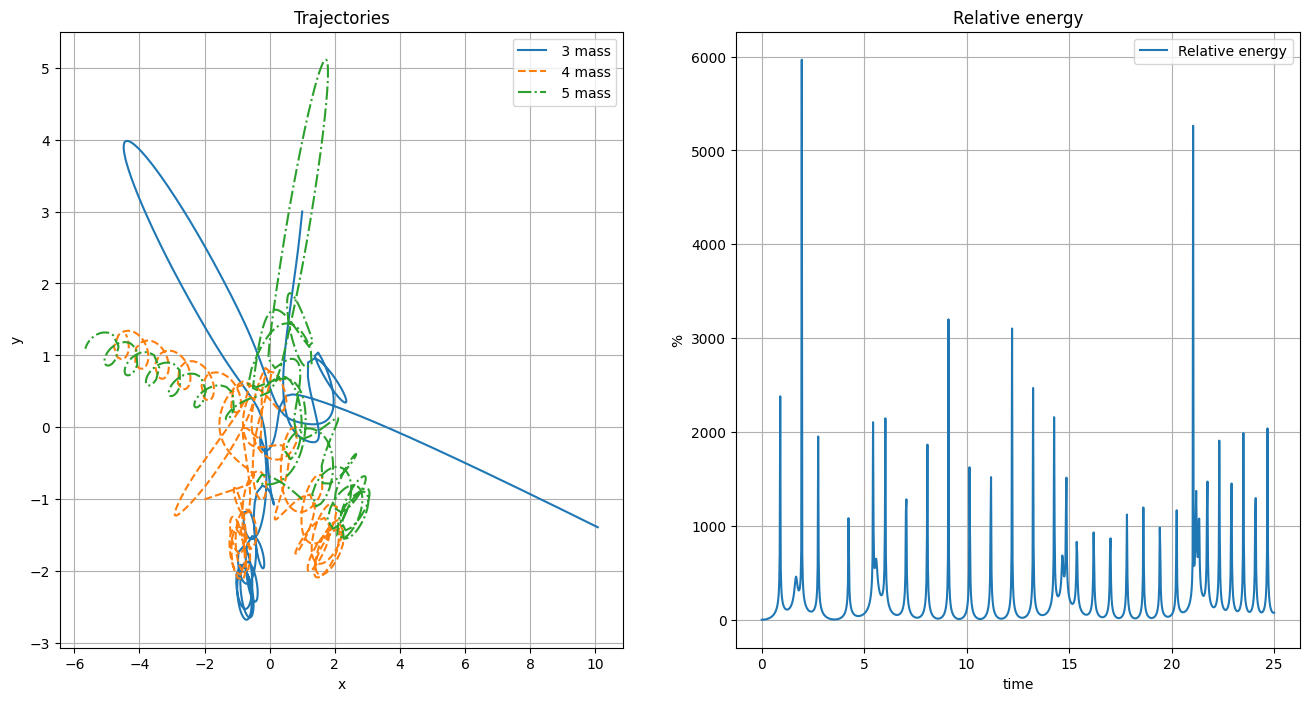

In [20]:

#With dense output I obtain an interpolating function
Y = solve_ivp(three_body_ODE, y0=y0, args=(G,M), t_span=(t0, tf), dense_output=True, rtol=1e-15,  atol=1e-15)
plot_orbits(Y.sol, t0=0, tf=25, N=1000)


With the standard Runge-Kutta method the system can't solved with enough accuracy, even with the smallest relative and absolute tollerance accepted by the algorithm. In this integration the system undergoes the loss of the mass 3 and the formation of a binary system already at t=25. Also the energy has spikes near the close encounters nearly up to 60 times its initial value.

In [ ]:
Y_rad = solve_ivp(three_body_ODE, y0=y0, args=(G,M), t_span=(t0, tf), method='Radau', dense_output=True, rtol=1e-15,  atol=1e-15)


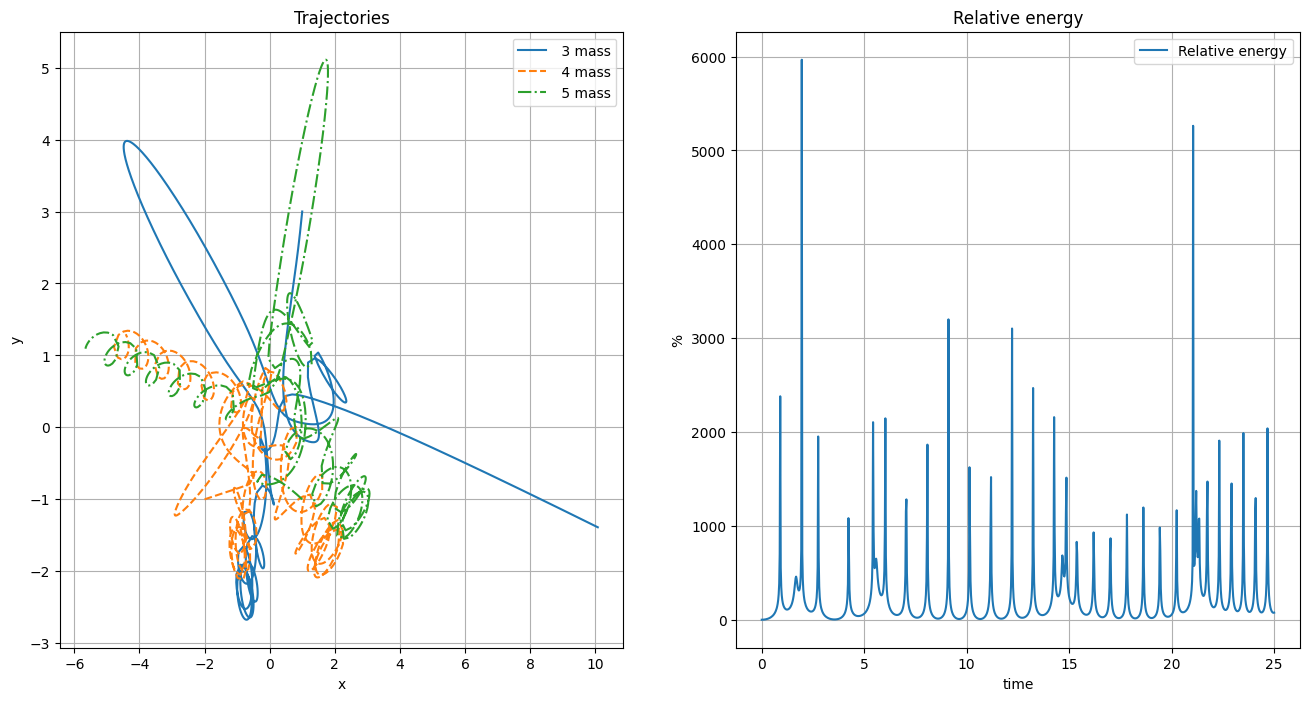

In [16]:
plot_orbits(Y_rad.sol, t0=0, tf=25)


Using the Radau integrator, that is described by the scipy documentation as more stable for stiff problems, the result is no better in terms of accuracy and the time required for integration is greater.

In [15]:
f = lambda t,y : three_body_ODE(t,y,G=G, M=M)

T, Y_RK = RK(f, y0=y0, t0=t0, tf=70, h=2e-5)


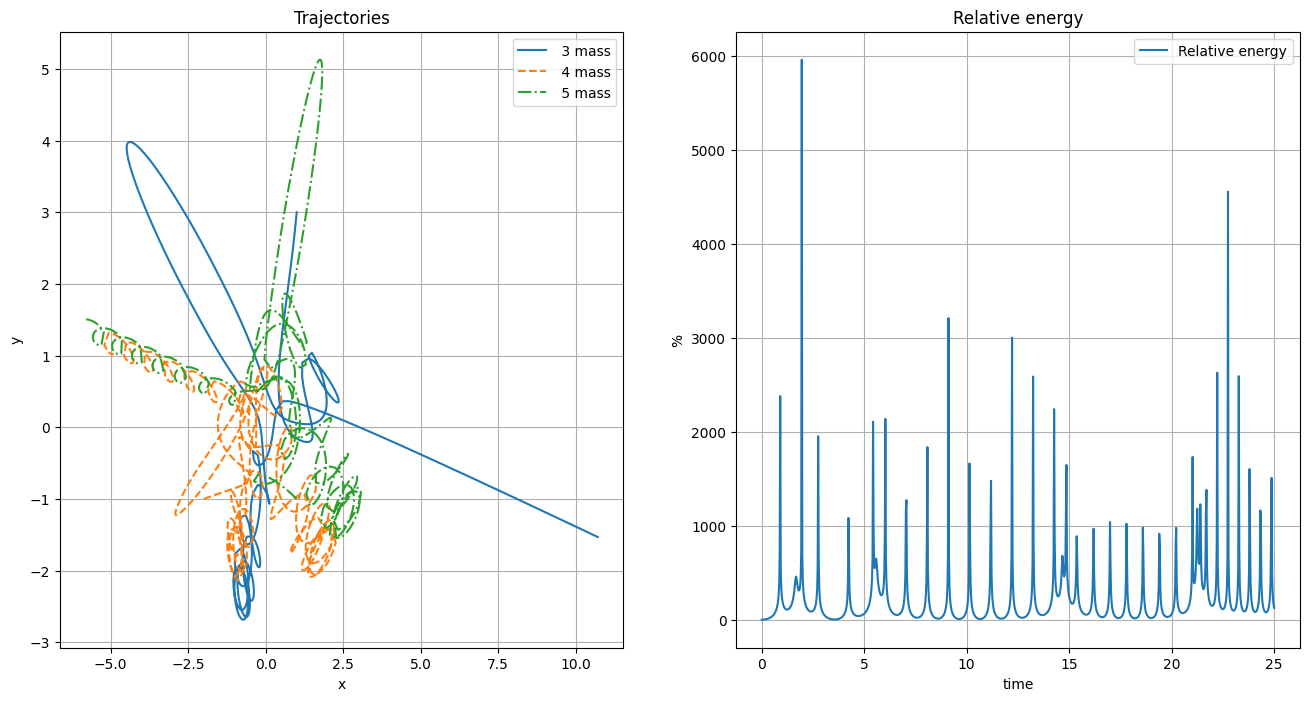

In [18]:
plot_orbits(Y_RK, t0=0, tf=25, N=10000)


Using the fixed-step Runge Kutta with a step $h=2 \cdot 10^{-5}$ causes the system to explode due to a close encounter around $t=20$, like the scipy Runge Kutta. Smaller, more precise step sizes would require times of integration of many hundreds of seconds because the method is not optimized by speed like the ones employed by scipy, which are written in compiled language like C or FORTRAN. 

To get better precision only when needed, I implemented the variable size-step Runge Kutta suggested by the professor uses as a step size:
$$ h(y)= \frac{h_0}{\frac{1}{r_{12}^2}+\frac{1}{r_{13}^2}+\frac{1}{r_{23}^2}} $$
As an experiment, I tried implementing also the function:
$$ h(y)= \frac{h_0}{(\frac{1}{r_{12}^2}+\frac{1}{r_{13}^2}+\frac{1}{r_{23}^2})^N} $$
varying the exponent $N$ to obtain extra precision when close encounters happen. As explained below, this failed due to increased amount of calculations that could not be performed efficiently on my computer

In [30]:
f = lambda t,y : three_body_ODE(t,y,G=G, M=M)
h_ada = lambda t,y: h(h0=5e-5, y=y, N=1)

_, Y_RKA = RK_Adaptive(f, y0=y0, t0=t0, tf=10, hf=h_ada)


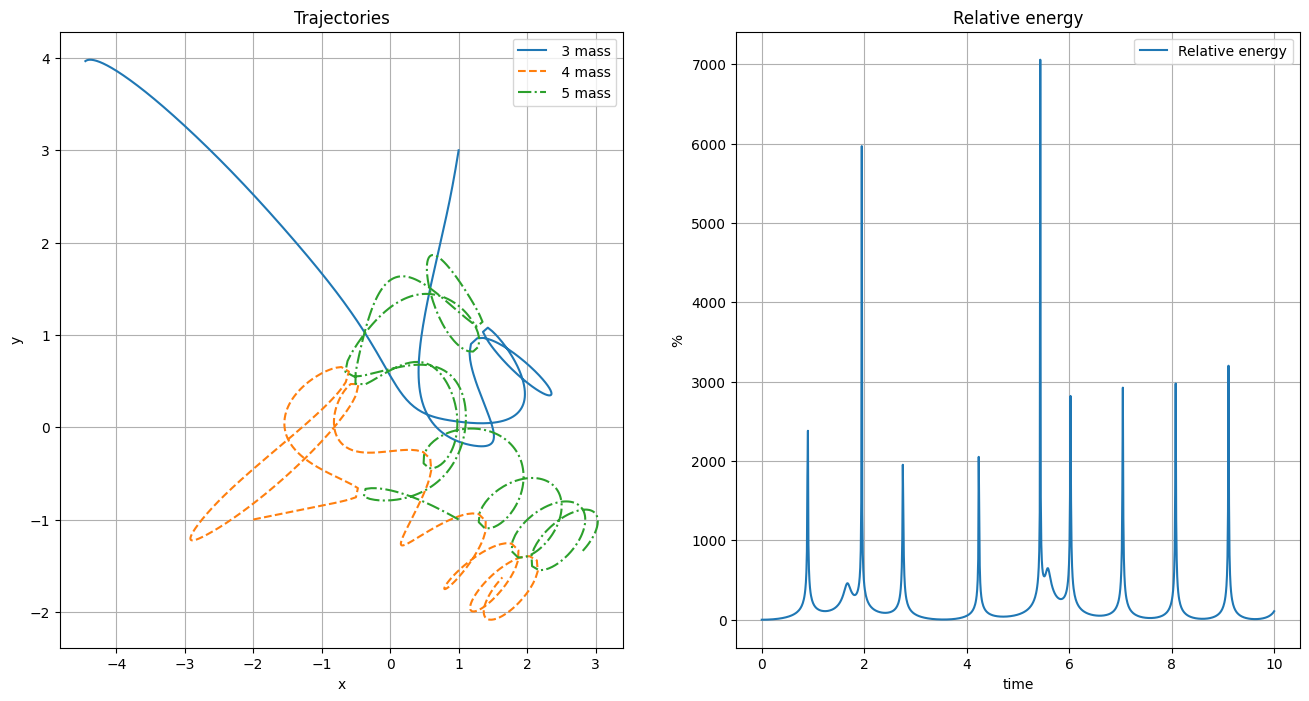

In [31]:
plot_orbits(Y_RKA, t0=0, tf=10)


With an initial step size of $5\cdot 10^{-5}$, the adaptive Runge Kutta has not achieved a better precision than the fixed one, as the spikes in the relative energy reach the same height as before.

In [16]:
f = lambda t,y : three_body_ODE(t,y,G=G, M=M)
h_ada = lambda t, y: h(h0=1e-3, y=y, N=1.5)

_, Y_RKA2 = RK_Adaptive(f, y0=y0, t0=t0, tf=5.0, hf=h_ada)



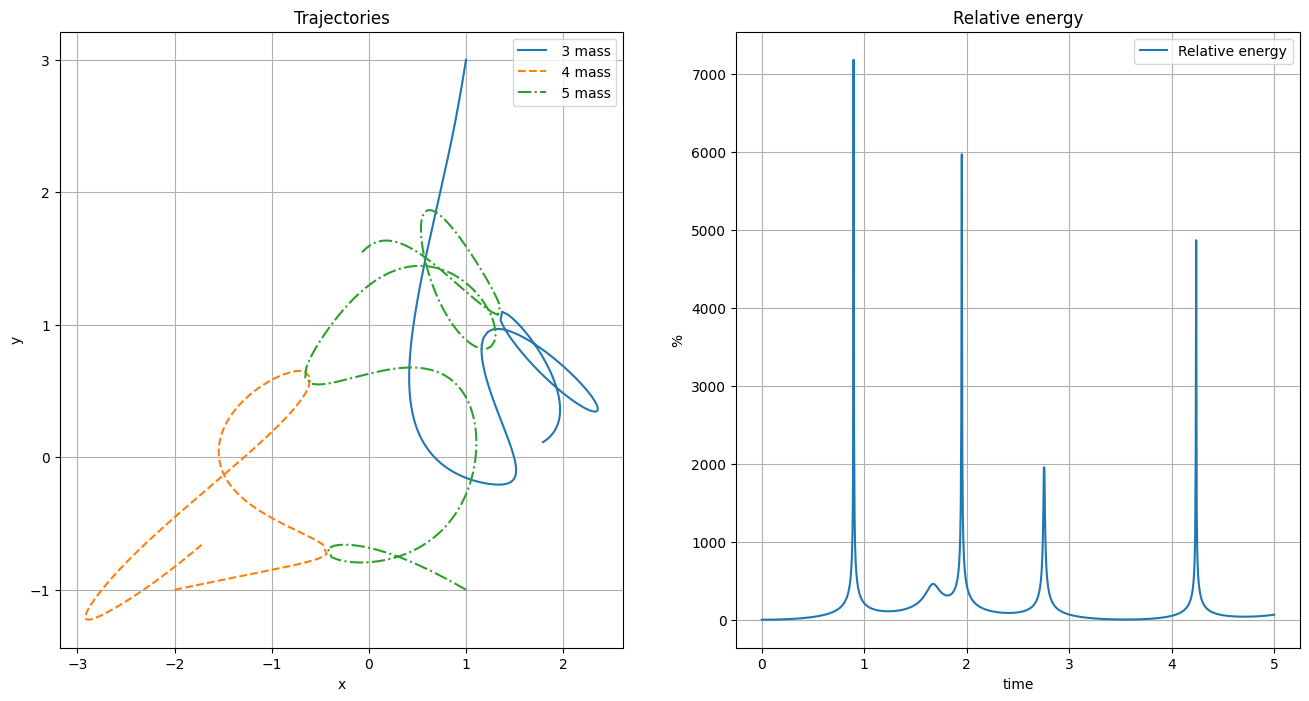

In [18]:
plot_orbits(Y_RKA2, t0=0, tf=5, N=10000)


Unexpectedly, my idea of increasing $N$ in the function to calculate the step size didn't work. The close encounters still impact pretty badly on the accuracy of the integration and the simulation take a long time, nearly twice as big as the fixed Runge Kutta, without improving performances in keeping the energy stable.

Finally, I tried integrating the problem with the 15th order, variable step size IAS15 integrator present in the **rebound** libray

In [29]:
# Import the rebound module
import rebound

# Create a REBOUND simulation
sim = rebound.Simulation()

# Default values are G=1, t=0, dt=0.01

sim.add( m=3.0, x=1.0, y=3, vx=0.0, vy=0.0)
sim.add( m=4.0, x=-2.0, y=-1, vx=0.0, vy=0.0)
sim.add( m=5.0, x=1.0, y=-1, vx=0.0, vy=0.0)

# timestep counter
T = np.linspace(0,70,10000)
y = []
# Integrate until t=1e4 (unit of time in this example is days)
for t in T:
    sim.integrate(t)
    # Print particle positions 
    y_t=[]
    for p in sim.particles:
        y_t.append([p.x, p.y])
    y.append(y_t)

y = np.array(y)
y = np.reshape(y, (len(T), 6))
y = y.T


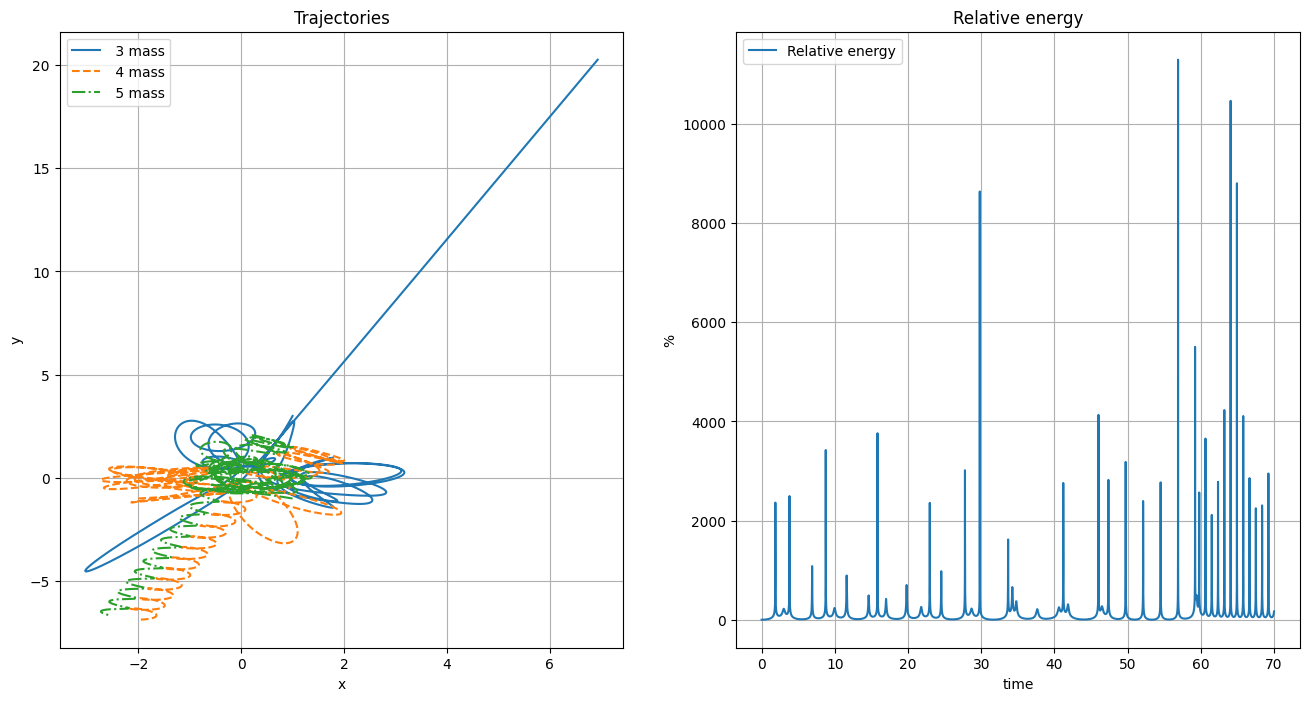

In [30]:
  x1, y1, x2, y2, x3, y3 = y[0], y[1], y[2], y[3], y[4], y[5]
  
  fig, axs = plt.subplots(1,2, figsize=(16,8))

  axs[0].set_title('Trajectories')
  axs[0].set_xlabel('x')
  axs[0].set_ylabel('y')
  axs[0].grid()
  axs[0].plot(x1, y1, linestyle = 'solid', label = ' 3 mass')
  axs[0].plot(x2, y2, linestyle = 'dashed', label = ' 4 mass')
  axs[0].plot(x3, y3, linestyle = 'dashdot', label = ' 5 mass')
  axs[0].legend(loc = 'best')

  axs[1].set_title('Relative energy')
  axs[1].set_xlabel('time')
  axs[1].set_ylabel('%')
  axs[1].plot(T, 100*relative_energy(y,G, M), label = 'Relative energy')
  axs[1].legend(loc = 'best')
  axs[1].grid()


Even with the IAS15 integrator the energy is not constant but the system correctly explodes around $t=60$ (visible in the energy plot where a lot of small, similar spikes are close to each other, corresponding to the now nearly periodic close encounters between the larger masses).

 
In general this integration has fewer and smaller enrgy spikes at the beginning, sign that the automatic step resize is working well. Probably some other manual integrators could reach a similar results, but they would require much more time and to be optimized for efficiency.